In [4]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary

## Structure of our data folder

For this exercise, we’ll keep the following folder structure:

<div> <img src="images/fig47.png" alt="Drawing" style="width: 300px;"/></div> 
![pic](https://raw.githubusercontent.com/CUTe-EmbeddedAI/images/main/images/fig47.png)

This is a straightforward folder structure with a root folder as the Train/Test folders containing classes with images inside them. 

*However, some other dataset, as you’ll see in the future, might have a slightly different structure. It doesn’t matter in what structure we get the data in. The data can all be in a single folder with class names in the image names (like “Cat_001.jpg”) or even in a CSV, we can process all this in our custom dataset class.

Let's apply some transformations to our data:

In [5]:
# Applying Transforms to the Data
import torchvision
import torchvision.transforms as transforms

image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}


## Method 1: Define dataset using `torchvision.datasets.ImageFolder`

In [3]:
# Load the Data

# Set train and valid directory paths

from google.colab import drive
drive.mount('/content/gdrive')

dataset = '/content/gdrive/My Drive/fruit_dataset'

train_directory = os.path.join(dataset, 'train')
test_directory = os.path.join(dataset, 'validation')

# Batch size
batchSize = 32

# Number of classes
num_classes = len(os.listdir(train_directory))
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),

    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
# idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
# print(idx_to_class)

Mounted at /content/gdrive
4


Let's see the info on train dataset

In [4]:
data['train']

Dataset ImageFolder
    Number of datapoints: 521
    Root location: /content/gdrive/My Drive/fruit_dataset/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [13]:
# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
# valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
trainloader = DataLoader(data['train'], batch_size=batchSize, shuffle=True)
# valid_data_loader = DataLoader(data['valid'], batch_size=batchSize, shuffle=True)
testloader = DataLoader(data['test'], batch_size=batchSize, shuffle=True)

In [6]:
train_data_size, test_data_size

(521, 323)

In [7]:
input_size = (3,32,32)

In [8]:
# #######################################################
# #                  Create Dataloader                     #
# #######################################################

# # Turn train and test custom Dataset's into DataLoader's
# from torch.utils.data import DataLoader
# trainloader = DataLoader(dataset=data['train'], # use custom created train Dataset
#                                      batch_size=4, # how many samples per batch?
#                                      num_workers=0, # how many subprocesses to use for data loading? (higher = more)
#                                      shuffle=True) # shuffle the data?

# testloader = DataLoader(dataset=data['test'], # use custom created test Dataset
#                                     batch_size=4, 
#                                     num_workers=0, 
#                                     shuffle=False) # don't usually need to shuffle testing data

# train_data_size = len(trainloader.dataset)
# test_data_size = len(testloader.dataset)

# print(train_data_size)
# print(test_data_size)

In [17]:
#######################
# DEFINE YOUR OWN MODEL

model_ft = models.convnext_tiny(pretrained=True)
num_ftrs = model_ft.classifier[2].in_features
# Here the size of each output sample is set to 10.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.classifier[2] = nn.Linear(num_ftrs, 4)

#######################

# 2. LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_ft.to(device)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate=none)
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96

In [11]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'cifar10_model_'+str(epoch)+'.pt')
            
    return model, history

In [18]:
# 4. Train the model for 10 epochs
 
num_epochs = 10
trained_model, history = train_and_validate(model_ft, criterion, optimizer, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 0.8489, Accuracy: 66.9866%, 
		Validation : Loss : 1.0697, Accuracy: 68.1115%, Time: 60.0124s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.4323, Accuracy: 89.6353%, 
		Validation : Loss : 0.8234, Accuracy: 81.7337%, Time: 19.5239s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.3405, Accuracy: 91.9386%, 
		Validation : Loss : 0.7511, Accuracy: 84.8297%, Time: 19.3454s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.3094, Accuracy: 91.9386%, 
		Validation : Loss : 0.6442, Accuracy: 84.5201%, Time: 19.7542s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.2957, Accuracy: 92.1305%, 
		Validation : Loss : 0.5723, Accuracy: 84.8297%, Time: 19.9335s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.2632, Accuracy: 92.1305%, 
		Validation : Loss : 0.6171, Accuracy: 83.9009%, Time: 19.4843s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.2516, Accuracy: 93.0902%, 
		Validation : Loss : 0.5045, Accuracy: 84.5201%, Time: 19.4592s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.2578, Accura

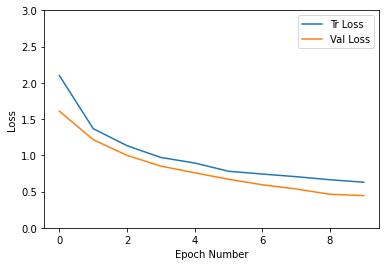

In [ ]:
# 5. Analyze the loss curve

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
# plt.savefig('cifar10_loss_curve.png')
plt.show()

In [20]:
# 6. Analyze the accuracy curve

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('cifar10_accuracy_curve.png')
plt.show()

TypeError: ignored

## Method 2: Define custom dataset in Pytorch

Pytorch has a great ecosystem to load custom datasets for training machine learning models.

This is a straightforward folder structure with a root folder as the Train/Test folders containing classes with images inside them. As we’ll see, it doesn’t matter in what structure we get the data in. The data can all be in a single folder with class names in the image names (like “Cat_001.jpg”) or even in a CSV, we can process all this in our custom dataset class.

![pic](https://raw.githubusercontent.com/CUTe-EmbeddedAI/images/main/images/fig47.png)


In [47]:
from torch.utils.data import Dataset, DataLoader

import cv2
import glob
import numpy
import random
from pandas.core.common import flatten
from PIL import Image

%matplotlib inline

import matplotlib.pyplot as plt

In [48]:
# Applying Transforms to the Data
import torchvision
import torchvision.transforms as transforms

image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}



Next, we create the Train, Valid, and Test sets. Here we create separate lists of image paths for Train, Valid, and Test sets. These will be used in our Dataset class which will be defined for a custom dataset.

In [49]:
from google.colab import drive
drive.mount('/content/gdrive')

dataset = '/content/gdrive/My Drive/fruit_dataset'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [50]:
####################################################
#       Create Train, Valid and Test sets
####################################################
train_data_path = dataset + '/train' 
test_data_path = dataset + '/validation'

train_image_paths = [] #to store image paths in list
classes = [] #to store class values

#1.
# get all the paths from train_data_path and append image paths and class to to respective lists

for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1]) 
    train_image_paths.append(glob.glob(data_path + '/*'))
    
train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

print('train_image_path example: ', train_image_paths[0])
print('class example: ', classes[0])

#2.
# create the test_image_paths
test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten(test_image_paths))

print("Train size: {}\nTest size: {}".format(len(train_image_paths), len(test_image_paths)))


train_image_path example:  /content/gdrive/My Drive/fruit_dataset/train/watermelon/19005c3813d836bf5c988273f93b424b55fbd706.jpg
class example:  watermelon
Train size: 521
Test size: 323


We can’t use the class names directly for models. We create mappings of classes to index and index to classes.

In [51]:
#######################################################
#      Create dictionary for class indexes
#######################################################

idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}
class_to_idx

{'watermelon': 0, 'durian': 1, 'pumpkin': 2, 'tomato': 3}

### Create Dataset Class

This is the core of our custom dataset. The structure of the dataset class is something like this:

![pic](https://raw.githubusercontent.com/CUTe-EmbeddedAI/images/main/images/fig48.png) 

We create our customDataset class by inheriting the Dataset class:

>from torch.utils.data import Dataset

First, we define the **init** function. As soon as we create an instance of our customDataset class, this function is called by default. This function should contain all operations that we want to run on the whole dataset (eg. train) once. For now, we define the variables for image_paths and transforms for the corresponding Train and Test sets.

Then we have the **len** function which just returns the length of the dataset. This is used afterward by the DataLoader to create batches.

And finally, we have **getitem**. This processes and returns 1 datapoint at a time.

In [52]:
from torch.utils.data import Dataset

#######################################################
#               Define Dataset Class
#######################################################

class fruitDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
#         image = cv2.imread(image_filepath)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.open(image_filepath) # if using torchvision transforms
        # print(image_filepath)
        label = image_filepath.split('/')[-2]
        # print(label)
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image) # if using torchvision transforms
        
        return image, label

As can be seen above, __getitem__ expects an index. This is handled automatically by the dataloader which for every image in the batch runs __getitem__. In the code for __getitem__, we load the image at index “idx”, extract the label from the file path and then run it through our defined transform. The function returns the Tensor of the image array and its corresponding label.

In [53]:
#######################################################
#                  Create Dataset
#######################################################

train_dataset = fruitDataset(train_image_paths,image_transforms['train'])
test_dataset = fruitDataset(test_image_paths,image_transforms['test'])

In [54]:
train_dataset.transform

Compose(
    RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    RandomHorizontalFlip(p=0.5)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

After creating the train_dataset, we can access one example as follows:

In [55]:
print('The shape of tensor for 50th image in train dataset: ',train_dataset[49][0].shape)
print('The label for 50th image in train dataset: ',train_dataset[49][1])

The shape of tensor for 50th image in train dataset:  torch.Size([3, 224, 224])
The label for 50th image in train dataset:  2


The final step. DataLoader class is used to load data in batches for the model. This helps us processing data in mini-batches that can fit within our GPU’s RAM. First, we import the DataLoader:

In [30]:
from torch.utils.data import DataLoader

Initiating the dataloader by sending in an object of the dataset and the batch size.

In [57]:
#######################################################
#                  Create Dataloader                     #
#######################################################

# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
trainloader = DataLoader(dataset=train_dataset, # use custom created train Dataset
                                     batch_size=32, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

testloader = DataLoader(dataset=test_dataset, # use custom created test Dataset
                                    batch_size=32, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

print(train_data_size)
print(test_data_size)

521
323


Once we have the dataloader instance — trainloader, we can use an iterator to access the data like this:

In [59]:
#batch of image tensor
next(iter(trainloader))[0].shape

torch.Size([32, 3, 224, 224])

In [ ]:
#batch of the corresponding labels
next(iter(trainloader))[1].shape

torch.Size([4])

This is what we use to batch out the data in our training loop. Every time we run the iterator, the dataloader selects the next 64 indexes and runs it through the __getitem__ in dataset class one by one and then returns it to the training loop.

In [58]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 4)

# 2. LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [43]:
import torch
from torchvision import models
from torchsummary import summary

model.to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [41]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'cifar10_model_'+str(epoch)+'.pt')
            
    return model, history

In [46]:
# 4. Train the model for 10 epochs
 
num_epochs = 10
trained_model, history = train_and_validate(model, criterion, optimizer, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 0.9980, Accuracy: 57.0058%, 
		Validation : Loss : 1.5033, Accuracy: 59.7523%, Time: 153.3365s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.4976, Accuracy: 85.2207%, 
		Validation : Loss : 1.5500, Accuracy: 64.7059%, Time: 152.6519s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.4071, Accuracy: 88.2917%, 
		Validation : Loss : 1.1713, Accuracy: 83.5913%, Time: 153.1737s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.2964, Accuracy: 92.3225%, 
		Validation : Loss : 1.1044, Accuracy: 83.2817%, Time: 153.1110s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.3106, Accuracy: 90.4031%, 
		Validation : Loss : 1.0244, Accuracy: 83.5913%, Time: 152.2708s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.2697, Accuracy: 92.7063%, 
		Validation : Loss : 0.9146, Accuracy: 83.5913%, Time: 152.8833s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.2362, Accuracy: 91.5547%, 
		Validation : Loss : 0.8906, Accuracy: 82.9721%, Time: 152.9411s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.2142,

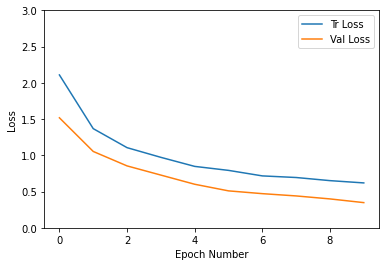

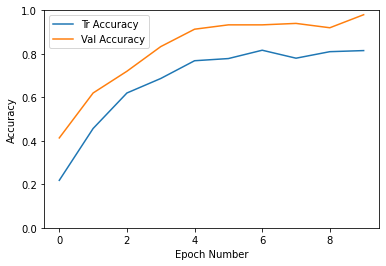

In [ ]:
# 5. Analyze the loss curve

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
# plt.savefig('cifar10_loss_curve.png')
plt.show()

# 6. Analyze the accuracy curve

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('cifar10_accuracy_curve.png')
plt.show()

## Inference on webcam

In [80]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time


# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [81]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [74]:
transform=transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
    ])



In [77]:
categories = ['thumbs_up','thumbs_down']

<IPython.core.display.Javascript object>

thumbs_up 0.6532006859779358


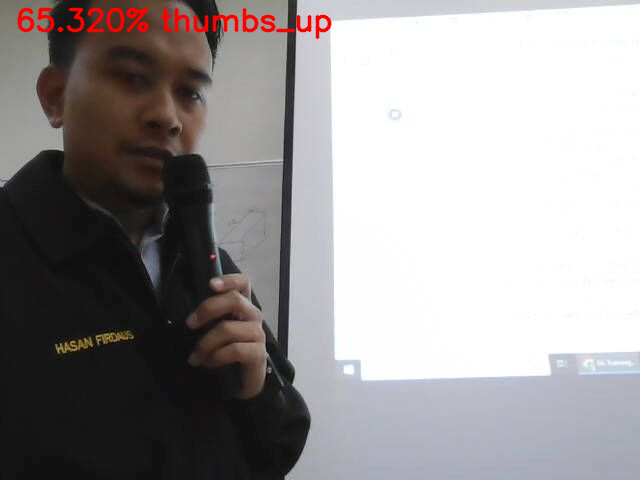

thumbs_up 0.6485223174095154


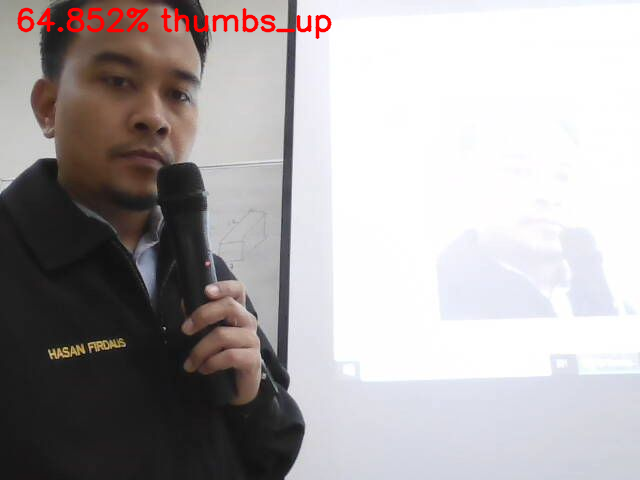

thumbs_up 0.6507171988487244


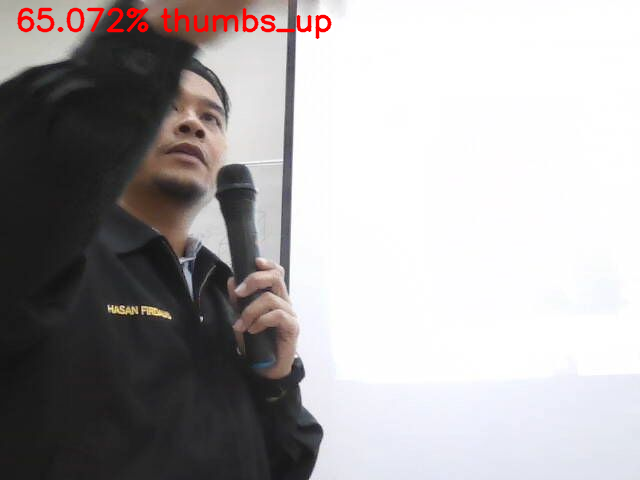

thumbs_up 0.6491987705230713


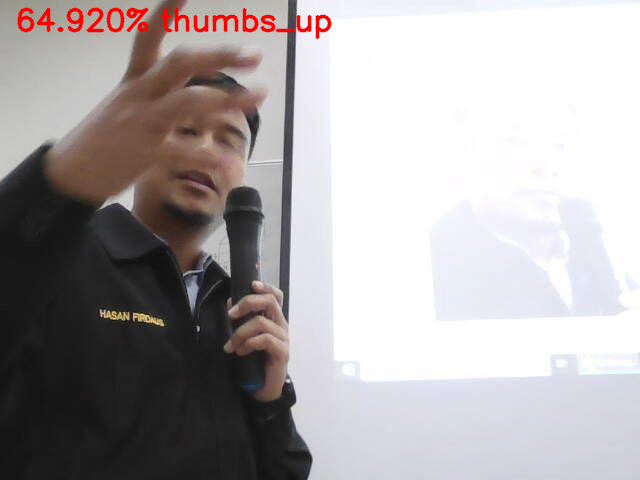

thumbs_up 0.6431822776794434


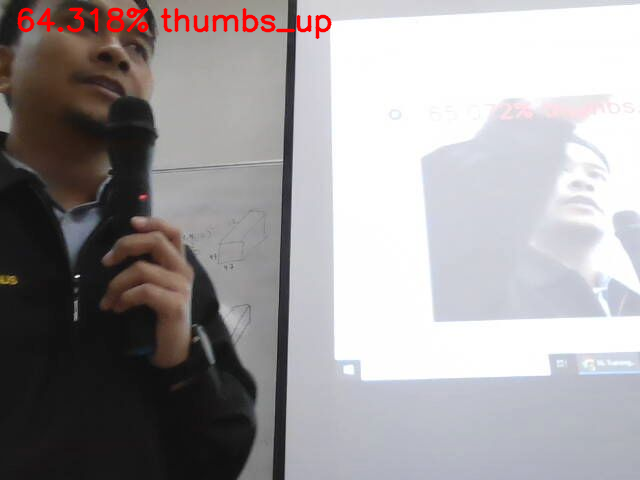

thumbs_up 0.647916853427887


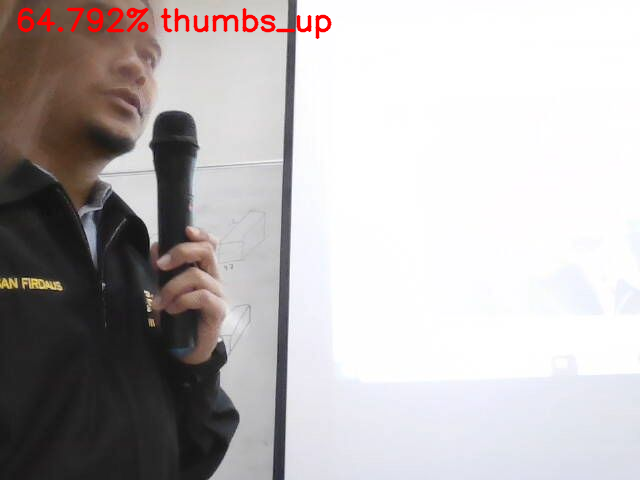

thumbs_up 0.6548389196395874


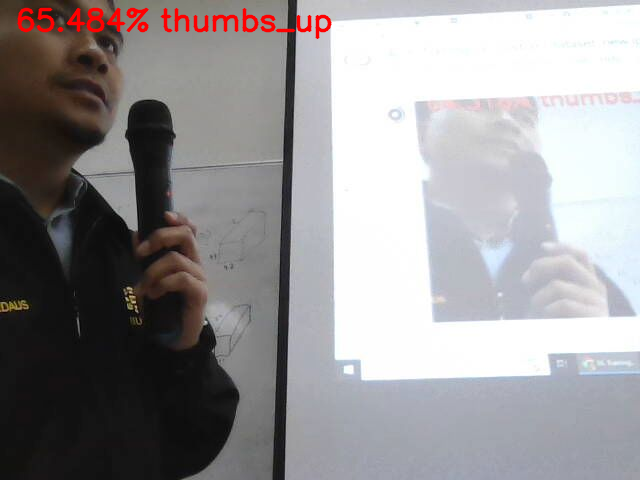

thumbs_up 0.6449660658836365


KeyboardInterrupt: ignored

In [82]:
from google.colab.patches import cv2_imshow
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    #     rgb_image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # Apply transforms to the input image.
    # input_tensor = transform(frame)
    input_tensor = transform(frame)
    # Add the batch dimension.
    input_batch = input_tensor.unsqueeze(0)
    input_batch = input_batch.to(device)
    
    with torch.no_grad():
        start_time = time.time()
        output = model(input_batch)
        end_time = time.time()
    # Get the softmax probabilities.
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    # Check the top 5 categories that are predicted.
    top5_prob, top5_catid = torch.topk(probabilities, 2)
    
    cv2.putText(frame, f"{top5_prob[0].item()*100:.3f}%", (15, (1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(frame, f"{categories[top5_catid[0]]}", (160, (1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    print(categories[top5_catid[0]], top5_prob[0].item())
    cv2_imshow(frame)

In [69]:
type(frame)

numpy.ndarray

In [71]:
frame.shape

(480, 640, 3)